In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
# Read the data
edges_df = pd.read_csv('../Data/edges.csv')
nodes_df = pd.read_csv('../Data/nodes.csv')
# Import nltk for lemmatization
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')
# Step 1: Get top 1000 artists by popularity
top_artists = nodes_df.nlargest(1000, 'popularity')

# Define the top 10 genres for classification
top_genres = {
    'pop': ['pop', 'k-pop', 'j-pop', 'cantopop', 'mandopop', 'synthpop', 'electropop'],
    'rock': ['rock', 'hard rock', 'punk rock', 'alternative rock', 'indie rock', 'classic rock'],
    'hip-hop': ['hip hop', 'rap', 'trap', 'gangsta rap', 'alternative hip hop'],
    'edm': ['edm', 'electronic', 'house', 'techno', 'dubstep', 'trance'],
    'r&b': ['r&b', 'soul', 'neo soul', 'funk'],
    'country': ['country', 'country pop', 'outlaw country'],
    'jazz': ['jazz', 'bebop', 'swing', 'cool jazz', 'fusion'],
    'classical': ['classical', 'orchestral', 'chamber music', 'baroque', 'romantic', 'symphony'],
    'latin': ['latin', 'reggaeton', 'salsa', 'bachata', 'latin pop'],
    'reggae': ['reggae', 'dub', 'dancehall']
}

# Step 2: Function to map genres to the top genres list
def map_to_top_genres(genre_str):
    if isinstance(genre_str, str):
        # Convert string to list format
        genre_list = [g.strip().strip("'") for g in genre_str.strip('[]').split(',')]
    elif isinstance(genre_str, list):
        # Directly assign if already a list
        genre_list = genre_str
    else:
        return []
    
    mapped_genres = set()
    for genre in genre_list:
        for top_genre, subgenres in top_genres.items():
            if any(sub in genre.lower() for sub in subgenres):
                mapped_genres.add(top_genre)
    return list(mapped_genres) if mapped_genres else []

# Apply the genre mapping function to top 1000 artists
top_artists['cleaned_genres'] = top_artists['genres'].apply(map_to_top_genres)
# Remove artists with empty genre lists
top_artists = top_artists[top_artists['cleaned_genres'].apply(len) > 0]

# Step 3: Function to expand 'chart_hits' into a list of dictionaries
def expand_chart_hits(chart_hits_str):
    if pd.isna(chart_hits_str) or chart_hits_str == '[]':
        return []
    
    try:
        chart_hits = ast.literal_eval(chart_hits_str)
        
        expanded = []
        for entry in chart_hits:
            country, hit_number = entry.replace("(", "").replace(")", "").split()
            expanded.append({
                'country_code': country,
                'hit_number': int(hit_number)
            })
        return expanded
    except Exception as e:
        print(f"Error processing chart hits: {e}")
        return []

# Step 4: Expand and aggregate chart hits data
expanded_hits = []
for idx, row in top_artists.iterrows():
    chart_data = expand_chart_hits(row['chart_hits'])
    for hit in chart_data:
        expanded_hits.append({
            'spotify_id': row['spotify_id'],
            'country_code': hit['country_code'],
            'hit_number': hit['hit_number']
        })

# Create a DataFrame for expanded chart hits
expanded_hits_df = pd.DataFrame(expanded_hits)

# Step 5: Aggregate total hits and number of countries for each artist
grouped_hits = expanded_hits_df.groupby('spotify_id').agg(
    total_hits=('hit_number', 'sum'), 
    num_countries=('country_code', 'nunique')
).reset_index()

# Merge aggregated hits data back into top_artists
top_artists = top_artists.merge(grouped_hits, on='spotify_id', how='left')
# Remove any artist with missing values in chart hits
top_artists = top_artists.dropna(subset=['total_hits', 'num_countries'])


# Step 6: Sort by total hits and get top 100 artists
top_artists = top_artists.sort_values(by='popularity', ascending=False)
top_artists = top_artists.head(100)

# Step 7: Remove outliers for numeric columns using 95% confidence interval
numeric_columns = ['followers', 'popularity']
for column in numeric_columns:
    # Calculate Q1, Q3 and IQR
    Q1 = top_artists[column].quantile(0.025)  # 2.5th percentile for 95% CI
    Q3 = top_artists[column].quantile(0.975)  # 97.5th percentile for 95% CI
    IQR = Q3 - Q1
    
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out outliers
    top_artists = top_artists[
        (top_artists[column] >= lower_bound) & 
        (top_artists[column] <= upper_bound)
    ]

top_artists

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dominusdeorum/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dominusdeorum/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,spotify_id,name,followers,popularity,genres,chart_hits,cleaned_genres,total_hits,num_countries
0,4q3ewBCX7sLwd24euuV69X,Bad Bunny,55669387.0,100,"['reggaeton', 'trap latino']","['us (76)', 'gb (1)', 'ar (91)', 'au (2)', 'at...","[latin, reggae, hip-hop]",2122.0,71.0
1,3TVXtAsR1Inumwj472S9r4,Drake,66852536.0,95,"['canadian hip hop', 'canadian pop', 'hip hop'...","['us (190)', 'gb (163)', 'ar (18)', 'au (148)'...","[pop, hip-hop]",5005.0,71.0
2,06HL4z0CvFAxyc27GXpf02,Taylor Swift,58554324.0,94,['pop'],"['us (136)', 'gb (115)', 'ar (24)', 'au (110)'...",[pop],3104.0,70.0
3,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,49387909.0,93,"['canadian contemporary r&b', 'canadian pop', ...","['us (81)', 'gb (74)', 'ar (23)', 'au (76)', '...","[pop, r&b]",3714.0,71.0
4,6KImCVD70vtIoJWnq6nGn3,Harry Styles,23284667.0,91,['pop'],"['us (35)', 'gb (35)', 'ar (23)', 'au (35)', '...",[pop],1487.0,71.0
...,...,...,...,...,...,...,...,...,...
107,181bsRPaVXVlUKXrxwZfHK,Megan Thee Stallion,7034241.0,82,"['dance pop', 'houston rap', 'pop', 'rap', 'tr...","['us (26)', 'gb (6)', 'ar (1)', 'au (6)', 'at ...","[pop, hip-hop]",295.0,67.0
108,6Xgp2XMz1fhVYe7i6yNAax,Trippie Redd,7909088.0,82,"['melodic rap', 'rap', 'trap']","['us (78)', 'gb (7)', 'au (5)', 'at (1)', 'be ...",[hip-hop],291.0,44.0
112,1DxLCyH42yaHKGK3cl5bvG,Maria Becerra,3091269.0,82,"['latin pop', 'pop argentino']","['ar (21)', 'bo (7)', 'cl (6)', 'co (1)', 'cr ...","[pop, latin]",94.0,17.0
110,7n2Ycct7Beij7Dj7meI4X0,TWICE,14818846.0,82,"['k-pop', 'k-pop girl group']","['us (1)', 'au (2)', 'bo (1)', 'bg (2)', 'ca (...",[pop],263.0,26.0


In [21]:
artist_collabs = pd.concat([edges_df['id_0'], edges_df['id_1']]).value_counts().reset_index()
artist_collabs.columns = ['spotify_id', 'collab_count']

top_artists_with_collabs = top_artists.merge(artist_collabs, on='spotify_id', how='left')
top_artists_with_collabs['collab_count'] = top_artists_with_collabs['collab_count'].fillna(0)
top_artists_with_collabs = top_artists_with_collabs[
    (top_artists_with_collabs['collab_count'] >= 
     top_artists_with_collabs['collab_count'].mean() - 2*top_artists_with_collabs['collab_count'].std()) &
    (top_artists_with_collabs['collab_count'] <= 
     top_artists_with_collabs['collab_count'].mean() + 2*top_artists_with_collabs['collab_count'].std())
]
top_artists_with_collabs

,spotify_id,name,followers,popularity,genres,chart_hits,cleaned_genres,total_hits,num_countries,collab_count
0,4q3ewBCX7sLwd24euuV69X,Bad Bunny,55669387.0,100,"['reggaeton', 'trap latino']","['us (76)', 'gb (1)', 'ar (91)', 'au (2)', 'at...","[latin, reggae, hip-hop]",2122.0,71.0,128.0
1,3TVXtAsR1Inumwj472S9r4,Drake,66852536.0,95,"['canadian hip hop', 'canadian pop', 'hip hop'...","['us (190)', 'gb (163)', 'ar (18)', 'au (148)'...","[pop, hip-hop]",5005.0,71.0,111.0
2,06HL4z0CvFAxyc27GXpf02,Taylor Swift,58554324.0,94,['pop'],"['us (136)', 'gb (115)', 'ar (24)', 'au (110)'...",[pop],3104.0,70.0,35.0
3,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,49387909.0,93,"['canadian contemporary r&b', 'canadian pop', ...","['us (81)', 'gb (74)', 'ar (23)', 'au (76)', '...","[pop, r&b]",3714.0,71.0,71.0
4,6KImCVD70vtIoJWnq6nGn3,Harry Styles,23284667.0,91,['pop'],"['us (35)', 'gb (35)', 'ar (23)', 'au (35)', '...",[pop],1487.0,71.0,0.0
...,...,...,...,...,...,...,...,...,...,...
95,181bsRPaVXVlUKXrxwZfHK,Megan Thee Stallion,7034241.0,82,"['dance pop', 'houston rap', 'pop', 'rap', 'tr...","['us (26)', 'gb (6)', 'ar (1)', 'au (6)', 'at ...","[pop, hip-hop]",295.0,67.0,68.0
96,6Xgp2XMz1fhVYe7i6yNAax,Trippie Redd,7909088.0,82,"['melodic rap', 'rap', 'trap']","['us (78)', 'gb (7)', 'au (5)', 'at (1)', 'be ...",[hip-hop],291.0,44.0,125.0
97,1DxLCyH42yaHKGK3cl5bvG,Maria Becerra,3091269.0,82,"['latin pop', 'pop argentino']","['ar (21)', 'bo (7)', 'cl (6)', 'co (1)', 'cr ...","[pop, latin]",94.0,17.0,31.0
98,7n2Ycct7Beij7Dj7meI4X0,TWICE,14818846.0,82,"['k-pop', 'k-pop girl group']","['us (1)', 'au (2)', 'bo (1)', 'bg (2)', 'ca (...",[pop],263.0,26.0,7.0


In [22]:
# Create a new dataframe with exploded genres
genre_artist_df = pd.DataFrame({
    'artist_name': top_artists_with_collabs['name'].repeat(top_artists_with_collabs['cleaned_genres'].str.len()),
    'genre': [genre for genres in top_artists_with_collabs['cleaned_genres'] for genre in genres]
})

# Display the first few rows to verify the structure
print("\nFirst few rows of the genre-artist relationship:")
print(genre_artist_df.head(10))

# Print total number of genre-artist relationships
print(f"\nTotal number of genre-artist relationships: {len(genre_artist_df)}")



First few rows of the genre-artist relationship:
    artist_name    genre
0     Bad Bunny    latin
0     Bad Bunny   reggae
0     Bad Bunny  hip-hop
1         Drake      pop
1         Drake  hip-hop
2  Taylor Swift      pop
3    The Weeknd      pop
3    The Weeknd      r&b
4  Harry Styles      pop
5           BTS      pop

Total number of genre-artist relationships: 154


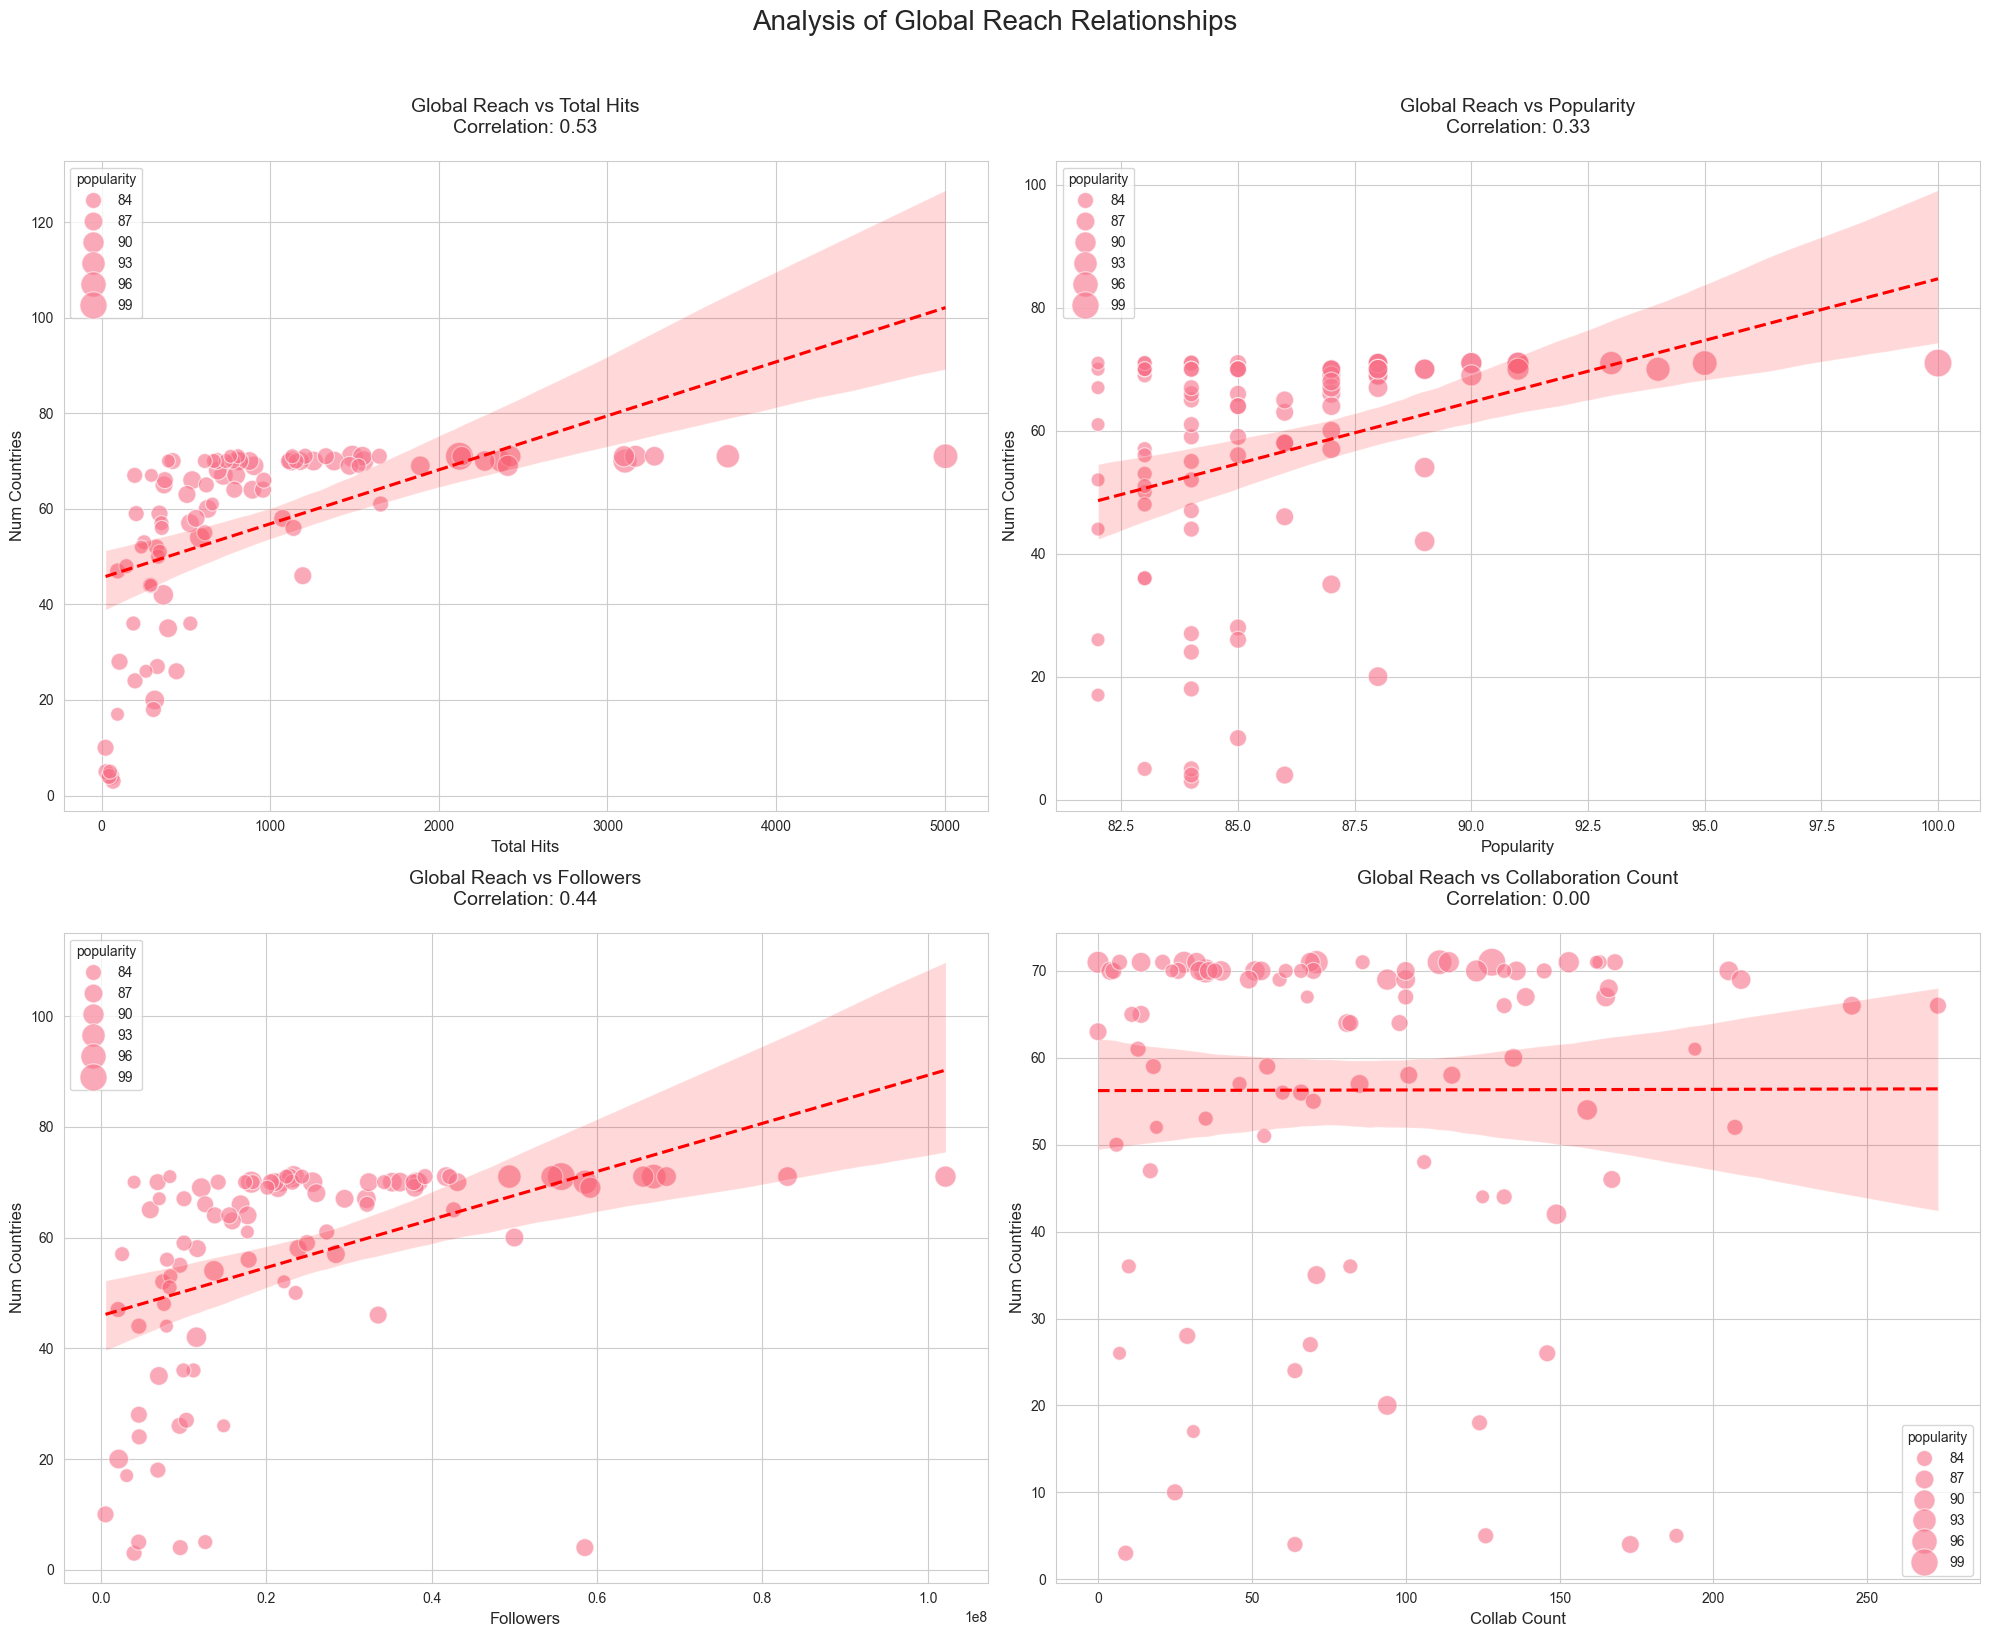


Summary Statistics for Global Reach Relationships:
Total Hits correlation with global reach: 0.529
Popularity correlation with global reach: 0.325
Followers correlation with global reach: 0.435
Collaborations correlation with global reach: 0.002


In [23]:
# Analyze relationships between global reach and other metrics
# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Analysis of Global Reach Relationships', fontsize=20, y=1.02)

# Helper function to create scatter plots with regression lines
def create_scatter_plot(ax, data, x_col, y_col, title):
    # Calculate correlation
    corr = data[x_col].corr(data[y_col])
    
    # Create scatter plot
    sns.scatterplot(data=data, 
                    x=x_col, 
                    y=y_col,
                    alpha=0.6,
                    size='popularity',
                    sizes=(100, 400),
                    ax=ax)
    
    # Add regression line
    sns.regplot(data=data,
                x=x_col,
                y=y_col,
                scatter=False,
                color='red',
                line_kws={'linestyle': '--'},
                ax=ax)
    
    # Customize plot
    ax.set_title(f'{title}\nCorrelation: {corr:.2f}', fontsize=14, pad=20)
    ax.set_xlabel(x_col.replace('_', ' ').title(), fontsize=12)
    ax.set_ylabel(y_col.replace('_', ' ').title(), fontsize=12)

# Plot 1: Global Reach vs Total Hits
create_scatter_plot(axes[0,0], 
                   top_artists_with_collabs, 
                   'total_hits', 
                   'num_countries',
                   'Global Reach vs Total Hits')

# Plot 2: Global Reach vs Popularity
create_scatter_plot(axes[0,1],
                   top_artists_with_collabs,
                   'popularity',
                   'num_countries',
                   'Global Reach vs Popularity')

# Plot 3: Global Reach vs Followers
create_scatter_plot(axes[1,0],
                   top_artists_with_collabs,
                   'followers',
                   'num_countries',
                   'Global Reach vs Followers')

# Plot 4: Global Reach vs Collaboration Count
create_scatter_plot(axes[1,1],
                   top_artists_with_collabs,
                   'collab_count',
                   'num_countries',
                   'Global Reach vs Collaboration Count')

# Adjust layout
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics for Global Reach Relationships:")
correlations = {
    'Total Hits': top_artists_with_collabs['total_hits'].corr(top_artists_with_collabs['num_countries']),
    'Popularity': top_artists_with_collabs['popularity'].corr(top_artists_with_collabs['num_countries']),
    'Followers': top_artists_with_collabs['followers'].corr(top_artists_with_collabs['num_countries']),
    'Collaborations': top_artists_with_collabs['collab_count'].corr(top_artists_with_collabs['num_countries'])
}

for metric, corr in correlations.items():
    print(f"{metric} correlation with global reach: {corr:.3f}")



Correlation Analysis:
Total Hits vs Popularity correlation: 0.718
Total Hits vs Followers correlation: 0.777


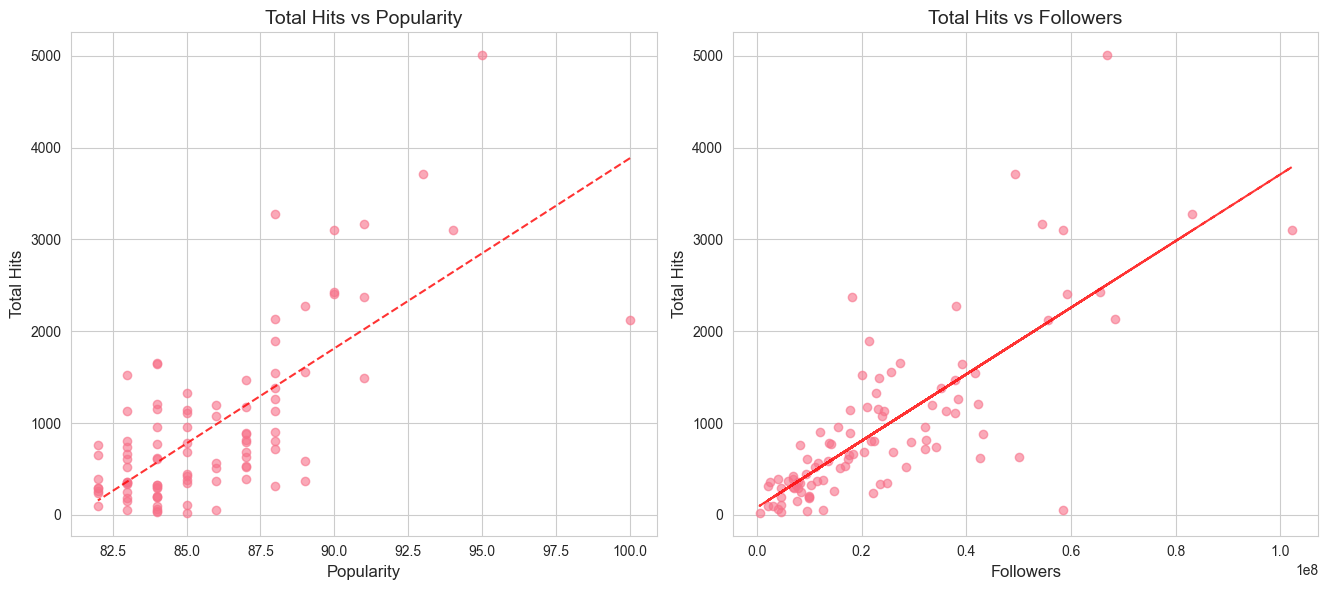

In [24]:
# Create a figure with 3 subplots
plt.figure(figsize=(20, 6))

# Plot 1: Total Hits vs Popularity
plt.subplot(131)
plt.scatter(top_artists_with_collabs['popularity'], 
           top_artists_with_collabs['total_hits'],
           alpha=0.6)

# Add regression line for popularity
z = np.polyfit(top_artists_with_collabs['popularity'], top_artists_with_collabs['total_hits'], 1)
p = np.poly1d(z)
plt.plot(top_artists_with_collabs['popularity'], p(top_artists_with_collabs['popularity']), "r--", alpha=0.8)

plt.xlabel('Popularity', fontsize=12)
plt.ylabel('Total Hits', fontsize=12)
plt.title('Total Hits vs Popularity', fontsize=14)

# Plot 2: Total Hits vs Followers
plt.subplot(132)
plt.scatter(top_artists_with_collabs['followers'], 
           top_artists_with_collabs['total_hits'],
           alpha=0.6)

# Add regression line for followers
z = np.polyfit(top_artists_with_collabs['followers'], top_artists_with_collabs['total_hits'], 1)
p = np.poly1d(z)
plt.plot(top_artists_with_collabs['followers'], p(top_artists_with_collabs['followers']), "r--", alpha=0.8)

plt.xlabel('Followers', fontsize=12)
plt.ylabel('Total Hits', fontsize=12)
plt.title('Total Hits vs Followers', fontsize=14)

# Print correlations
print("\nCorrelation Analysis:")
print(f"Total Hits vs Popularity correlation: {top_artists_with_collabs['total_hits'].corr(top_artists_with_collabs['popularity']):.3f}")
print(f"Total Hits vs Followers correlation: {top_artists_with_collabs['total_hits'].corr(top_artists_with_collabs['followers']):.3f}")

plt.tight_layout()
plt.show()


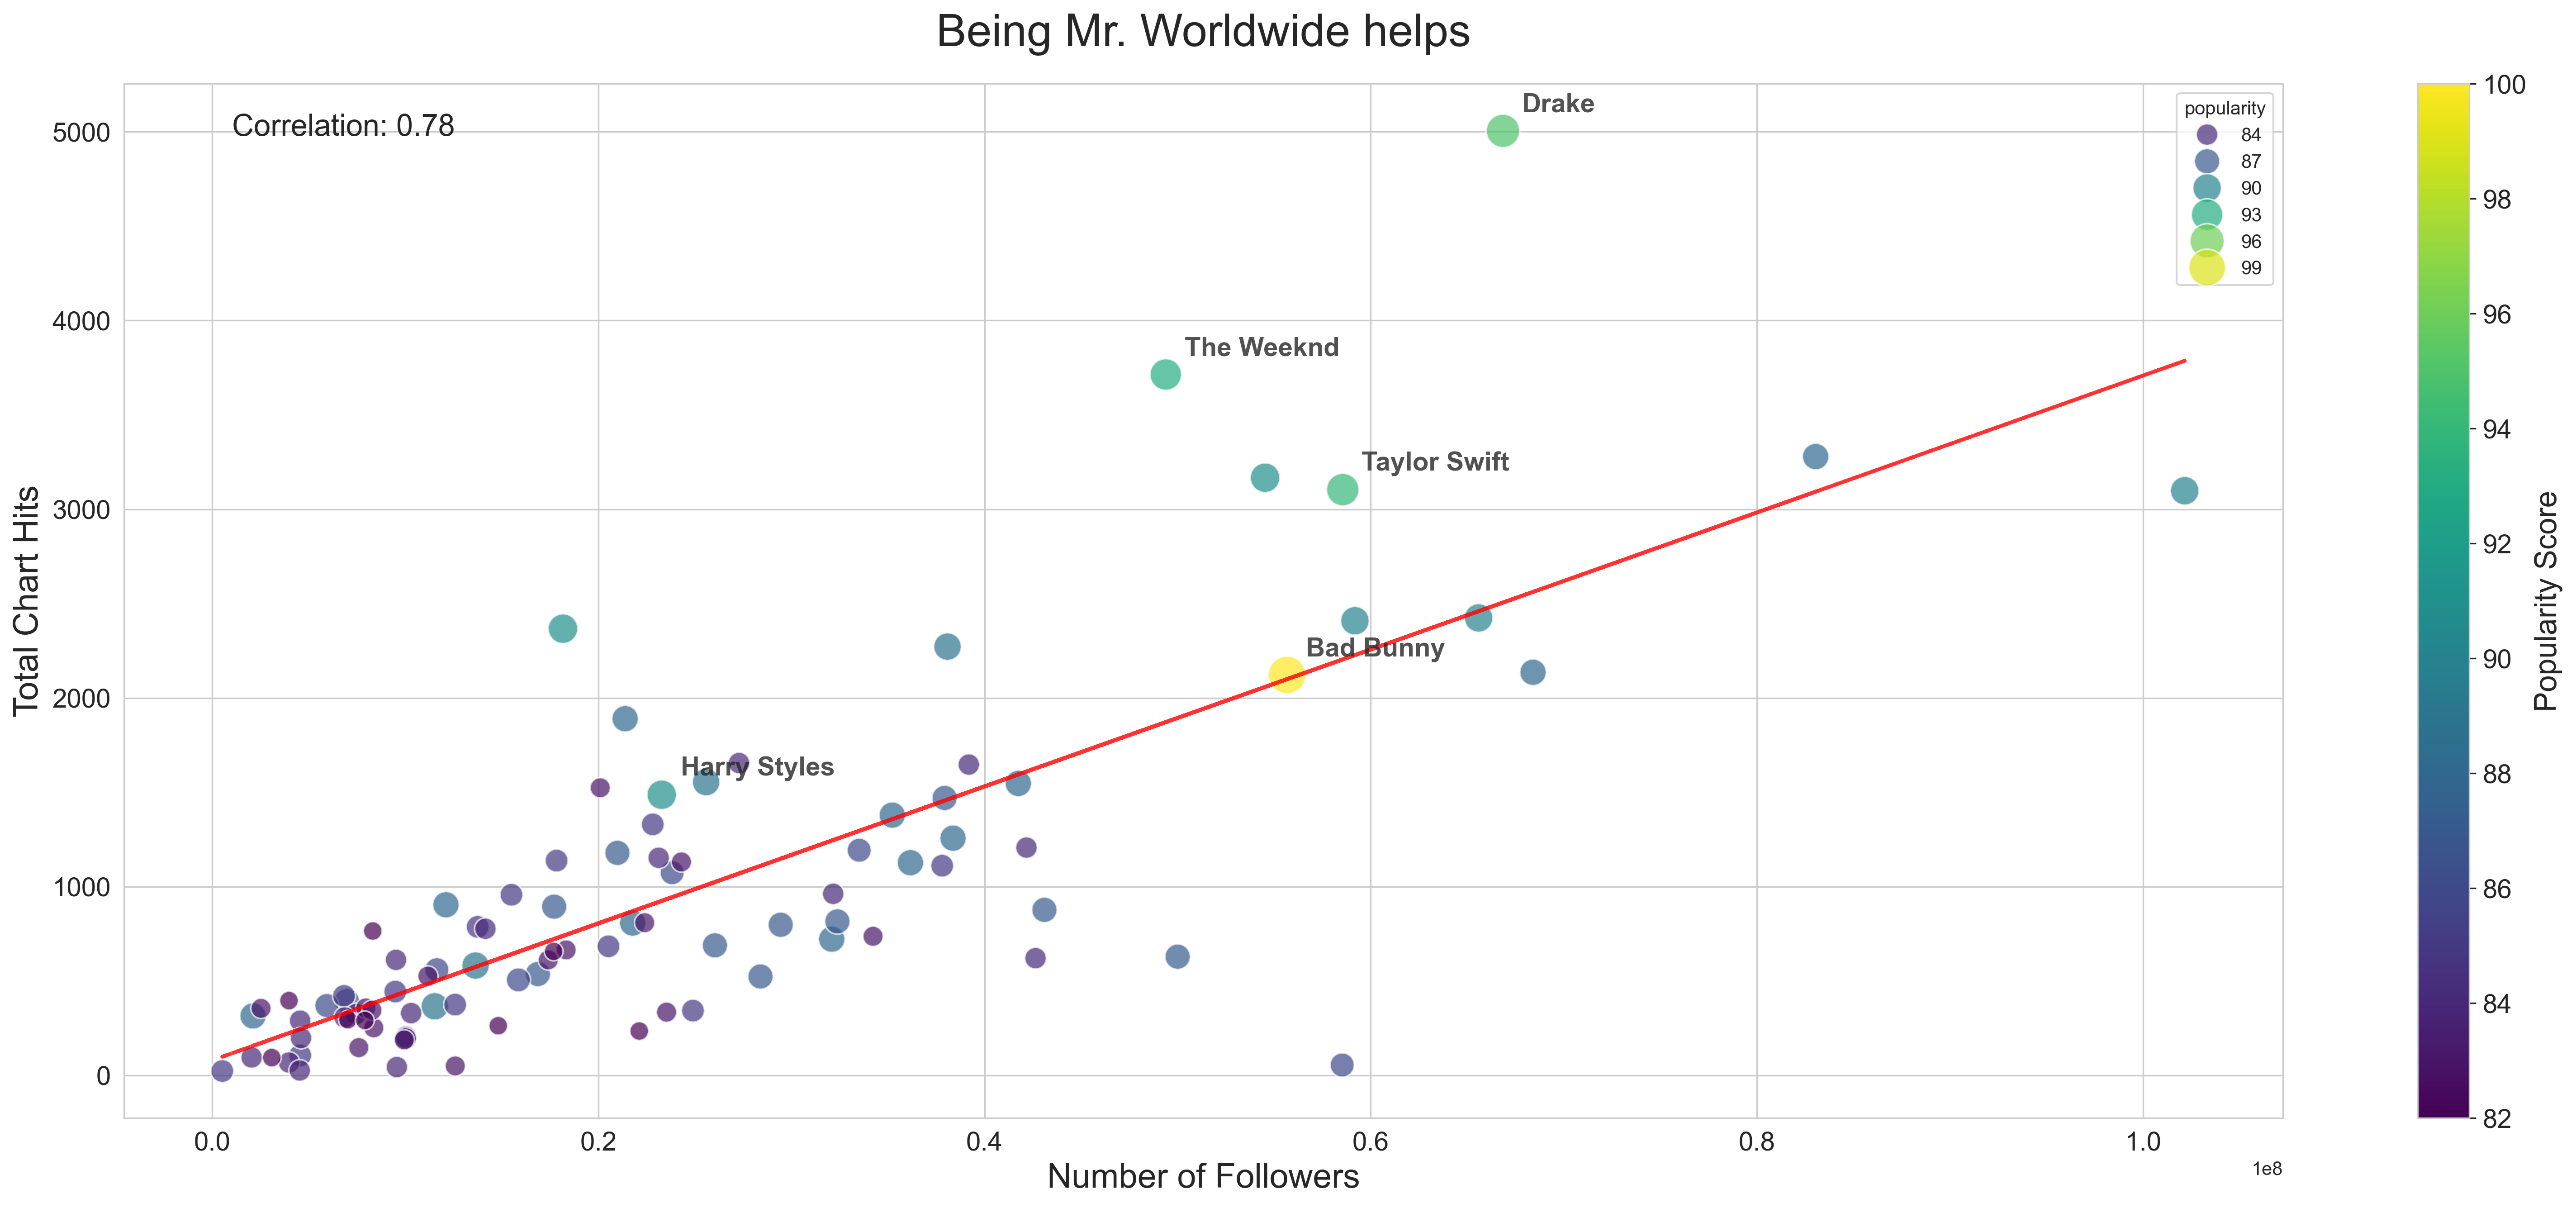

In [25]:
# Create a beautiful scatter plot using seaborn with high DPI
fig, ax = plt.subplots(figsize=(21, 9), dpi=300)

# Create scatter plot with color gradient based on popularity
scatter = sns.scatterplot(data=top_artists_with_collabs,
                x='followers',
                y='total_hits',
                hue='popularity',
                size='popularity',
                sizes=(100, 400),
                alpha=0.7,
                palette='viridis',
                ax=ax)

# Add regression line
x = top_artists_with_collabs['followers']
y = top_artists_with_collabs['total_hits']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x, p(x), "r--", alpha=0.8, linewidth=2)

# Calculate and display correlation coefficient
corr = x.corr(y)
ax.text(0.05, 0.95, f'Correlation: {corr:.2f}', 
        transform=ax.transAxes, fontsize=16)

# Customize the plot
ax.set_title('Being Mr. Worldwide helps', fontsize=24, pad=20)
ax.set_xlabel('Number of Followers', fontsize=18)
ax.set_ylabel('Total Chart Hits', fontsize=18)

# Increase tick label sizes
ax.tick_params(axis='both', which='major', labelsize=14)

# Add a color bar legend
norm = plt.Normalize(top_artists_with_collabs['popularity'].min(), 
                    top_artists_with_collabs['popularity'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Popularity Score", fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Annotate some interesting points
for idx, row in top_artists_with_collabs.head(5).iterrows():
    ax.annotate(row['name'],
                xy=(row['followers'], row['total_hits']),
                xytext=(10, 10),
                textcoords='offset points',
                fontsize=14,
                alpha=0.8,
                weight='bold')

plt.tight_layout()
plt.show()
